# Image Classification for Optical Character Recognition (OCR)

**Python** version: 3.7.7   
**numpy** version: 1.19.0   
**matplotlib** version: 3.2.2  
**scikit-image** version: 0.17.2  
**scikit-learn** version: 0.23.1  
**joblib** version: 0.16.0  

This Python Jupyter notebook introduces some basic image processing techniques that can be used in the context of optical character recognition (OCR). It combines methods such as image flattening and image reconstruction with basic machine learning approaches.   
The data used for the training and validation of a machine learning (ML) classifier is extracted from weather tables form the [Bozner Zeitung](https://digital.tessmann.it/tessmannDigital/Zeitungsarchiv/Jahresuebersicht/Zeitung/2) (year 1844). Predictions are made on data from the same newspaper, but from another year (year 1842).

The required libraries are loaded:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage import transform

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from joblib import dump
from joblib import load

## Data loading

The training and validation dataset to be used in the machine learning approach is loaded from a csv-file and stored in a list (**data_list**).

In [2]:
data_file = open("digits_0-9.csv", "r")
data_list = data_file.readlines()
data_file.close()

In [3]:
len(data_list)

2067

The data list contains 2067 items, each one representing the data for one image. In order to get an impression of the data structure, we look at one individual item (e.g. the item with index 2000 in the data list):  

In [4]:
item_2000 = data_list[2000]
print("Data points in item: " + str(item_2000.count(',') + 1))
print(" ")
print("Data content of item: ")
print(" ")
print(item_2000)

Data points in item: 1876
 
Data content of item: 
 
255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255

The item contains 1876 data points, separated by commas. The first 1875 data points represent pixel values of a square image with 25 x 25 pixels organized in 3 channels (8-bit, RGB). The last character (9) is the label of the image.

## Image reconstruction for data visualization

In the data list, the images are provided in a flatten format. In order to visualize them, they need to be reconstructed to the initial shape. This operation requires 2 steps:  
- separation of the pixel values from the label value  
- reshaping the flat data line in an array with shape 25x25x3 (25x25 pixels in 3 channels).

These operations are performed by the following method:

In [5]:
def datalist_element_label(datalist_element):
    
    data_element_raw = datalist_element
    data_element_label = data_element_raw[-2:-1]
    data_element = data_element_raw[0:-2]
    data_element_str = data_element.split(",")[:-1]
    data_element_int = [int(x) for x in data_element_str]
    image_array = np.asfarray(data_element_int).reshape((25,25,3))
    
    return image_array, data_element_label

By applying this method to some items in the data list, we can reconstruct the respective images and also show the labels of each image. This is done for 10 random images.

In [6]:
indices = np.random.randint(0, 2066, size=10)
elements = [data_list[x] for x in indices]

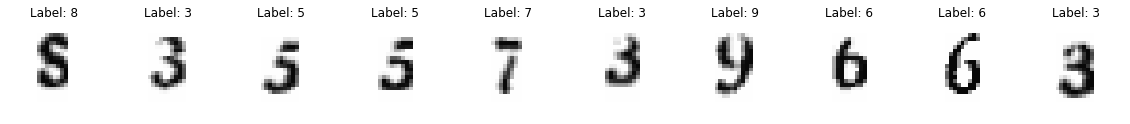

In [7]:
plt.figure(figsize=(20,5))

for i in range (0,10):
    img = datalist_element_label(elements[i])[0]
    label = datalist_element_label(elements[i])[1]
    
    plt.subplot(1,10,i + 1)
    plt.imshow(img.astype(np.uint8), cmap="gray")
    plt.axis("off")
    plt.title("Label: " + label)

plt.show()

## Data preparation for machine learning

Machine learning requires some data preparation first. Since the data in the data list is a mixture of pixel values and image labels, it needs to be split accordingly. This can be done by using the **datalist_element_label** method defined above.

In this notebook, we use the machine learning library [**scikit-learn**](https://scikit-learn.org/stable/). The ML-algorithms in scikit-learn can be used with arrays of linearized data. The data is therefore converted in such arrays.

In [8]:
img_lin = []
labels = []

for item in data_list:
    img = datalist_element_label(item)[0]
    img_linear = np.reshape(img, img.shape[0]*img.shape[1]*img.shape[2])
    label = datalist_element_label(item)[1]
    img_lin.append(img_linear)
    labels.append(label)

The result is a list of pixel values, organized in arrays (**img_lin**), and a list of image labels (**labels**) finally converted to an array (**categories**).

In [9]:
len(img_lin) 

2067

In [10]:
print(img_lin[2000])

[255. 255. 255. ... 255. 255. 255.]


In [11]:
len(labels) 

2067

In [12]:
print(labels[2000])

9


In [13]:
categories = np.asarray(labels, dtype='<U2')

In [14]:
print(categories)

['0' '0' '0' ... '9' '9' '9']


## Training a machine learning algorithm

In order to train and validate a machine learning algorithm, the data needs to be divided in a training and a validation data set.  
A good splitting rate is 80/20 (80 % training data, 20 % validation data).

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(img_lin, categories, test_size=0.2, random_state=0)

The training data set is used to train a **Random Forest Classifier** with 1000 estimators.

In [16]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)

RandomForestClassifier(n_estimators=1000)

In [17]:
ypred = model.predict(Xtest)

The performance of the trained model is checked on the validation data set:

In [18]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.98      0.98      0.98        43
           2       1.00      1.00      1.00        56
           3       0.97      1.00      0.98        29
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        28
           6       1.00      0.99      0.99        73
           7       1.00      0.98      0.99        42
           8       1.00      1.00      1.00        42
           9       0.98      1.00      0.99        51

    accuracy                           0.99       414
   macro avg       0.99      0.99      0.99       414
weighted avg       0.99      0.99      0.99       414



Depending on the character type, the prediction accuracy is roughly between 97 % and 100 %. This (improvable) prediction accuracy reflects the rather small amount of data used for training.

## Testing the trained algorithm on new data

The trained algorithm can be used to predict labels for new data.  
Loading of the prediction data:

In [19]:
prediction_path = "predict_img/"

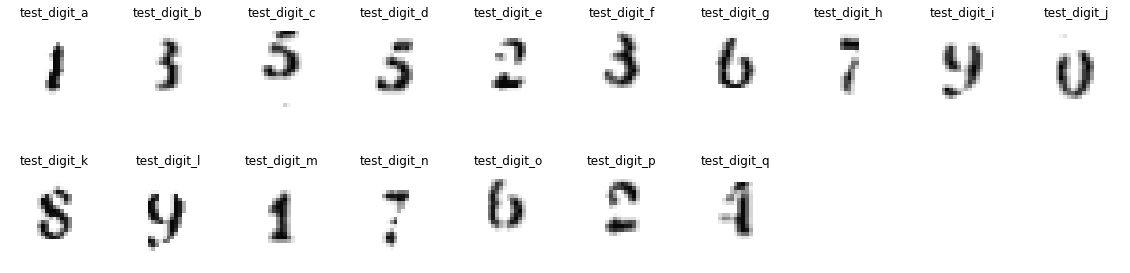

In [20]:
plt.figure(figsize=(20,5))

for index, file in enumerate(os.listdir(prediction_path)):
    img = skimage.io.imread(prediction_path + file)    
    plt.subplot(2, 10, index + 1)
    plt.imshow(img.astype(np.uint8), cmap="gray")
    plt.axis("off")
    plt.title(file[:-4])

plt.show()

After loading, the prediction data has to be flattened (as shown for the training data) and presented to the model, which then predicts the label:

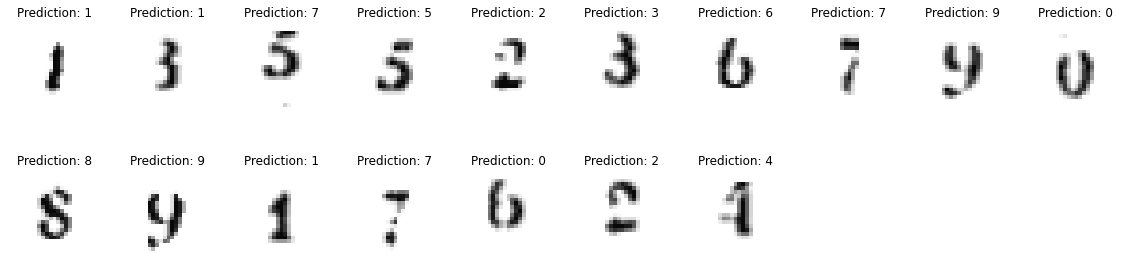

In [21]:
plt.figure(figsize=(20,5))

for index, file in enumerate(os.listdir(prediction_path)):
    img = skimage.io.imread(prediction_path + file)
    img_linear = np.reshape(img, img.shape[0]*img.shape[1]*img.shape[2])
    img_linear_single = img_linear.reshape(1, -1)
    ypred = model.predict(img_linear_single)
    
    plt.subplot(2, 10, index + 1)
    plt.imshow(img.astype(np.uint8), cmap="gray")
    plt.axis("off")
    plt.title("Prediction: " + ypred[0])

plt.show()

The trained algorithm provided some useful predictions, even though the prediction quality is improvable. A substantial improvement can be achieved by increasing the amount of training data, for example by means of data augmentation (not described in this notebook).

## Saving the trained model for further use

Trained machine learning models can be saved and reused. For saving, we use the **dump** method, for loading the **load** method.

In [22]:
dump(model, "cc_trained_algorithm.joblib")

['cc_trained_algorithm.joblib']

In [23]:
loaded_model = load("cc_trained_algorithm.joblib") 

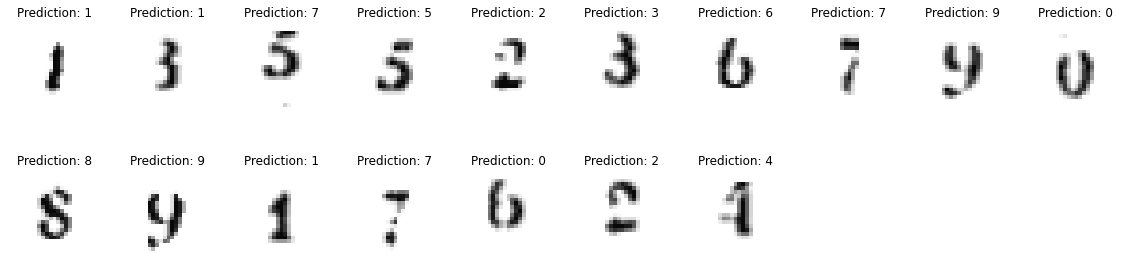

In [24]:
plt.figure(figsize=(20,5))

for index, file in enumerate(os.listdir(prediction_path)):
    img = skimage.io.imread(prediction_path + file)
    img_linear = np.reshape(img, img.shape[0]*img.shape[1]*img.shape[2])
    img_linear_single = img_linear.reshape(1, -1)
    ypred = loaded_model.predict(img_linear_single)
    
    plt.subplot(2, 10, index + 1)
    plt.imshow(img.astype(np.uint8), cmap="gray")
    plt.axis("off")
    plt.title("Prediction: " + ypred[0])

plt.show()